# Set up Environment

In [1]:
import os

# use either 'tensorflow' or 'theano'
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
# import keras tools
from keras.models import Input, Model
from keras.layers import Conv1D, Dense, Activation, MaxPool1D, Dropout
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.utils.np_utils import to_categorical

# import numpy, sklearn (generate data), matplotlib (ploting)
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt

# for setting random seed
from numpy.random import seed
from tensorflow import set_random_seed

%matplotlib inline

Using TensorFlow backend.


# Core function: cnn_1d

In [3]:
def cnn_1d(n_rows, n_cols, n_filters, n_classes, n_pool=1, learning_rate=0.005):
    # the input layer
    data_input = Input(shape=(n_rows, n_cols))

    l1 = 0
    l2 = 1e-4
    coeff_activity = 0.0

    # the filters
    convolution = Conv1D(
        n_filters,
        1,
        activation='relu',
        kernel_regularizer=l1_l2(l1=l1, l2=l2),
        strides=1,
        padding='same',
        name='conv1'
    )(data_input)
    
    #convolution = Dropout(rate=0.5)(convolution)
    #convolution = Activation('relu')(convolution)

    # the cell grouping part
    pooled = MaxPool1D(pool_size=n_pool)(convolution)

    # network prediction output
    output = Dense(
        n_classes,
        activation='softmax',
        kernel_regularizer=l1_l2(l1=l1, l2=l2),
        name='output'
    )(pooled)
    #)(convolution)

    model = Model(inputs=data_input, outputs=output)

    model.compile(
        optimizer=Adam(lr=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Concept: Categorical crossentropy

Given samples and labels $(x, y)$

What we want: $\hat{y} \approx y$

Loss function: $L(\hat{y}, y)$
- **if y is continuous data**
    - distance between $\hat{y}$ and $y$ 
    - $\rightarrow L(\hat{y}, y) =  \parallel \hat{y}, y \parallel^2 = (\hat{y} - y)^2$
    

- **if y is categorical** -> where each label indicate which category an observation is
    - suppose there are two categories $y = 0$ or $y = 1$
        - $L(\hat{y}, y) = - \big[y \text{log}(\hat{y}) + (1 - y) \text{log}(1 - \hat{y})\big]$
        - **$\hat{y}$ here can be intepreted as P(Y = 1)**
        - **$1 - \hat{y}$ here can be intepreted as P(Y = 0)**
    - **if y = 0**
        - $\Rightarrow L(\hat{y}, y) = - \text{log}(1 - \hat{y})$
        - $\hat{y} \approx 0 \rightarrow L(\hat{y}, y) \approx - \text{log}(1) = 0$
        - $\hat{y} \approx 1 \rightarrow L(\hat{y}, y) \approx - \text{log}(1 - 1) = -(-\infty) = \infty$
    - **if y = 1**
        - $\Rightarrow L(\hat{y}, y) = - \text{log}(\hat{y})$
        - $\hat{y} \approx 0 \rightarrow L(\hat{y}, y) \approx - \text{log}(0) = -(-\infty) = \infty$
        - $\hat{y} \approx 1 \rightarrow L(\hat{y}, y) \approx - \text{log}(1) = 0$


- **if there are three categories**    
    - each label $y = \big[y_0, y_1, y_2\big]$
        - category 0 -> $y = [ 1, 0, 0 ]$
        - category 1 -> $y = [ 0, 1, 0 ]$
        - category 2 -> $y = [ 0, 0, 1 ]$
    - $\hat{y} = \big[P(Y = 0), P(Y = 1), P(Y = 2)\big] = \big[\hat{y}_0, \hat{y}_1, \hat{y}_2\big]$
    - The loss function can be written as
        - $L(\hat{y}, y) = - \sum y_i \text{log} \hat{y}_i$

# Generate Simple Data

### Summary of Data
- two features: X and Y ---> n_features = 2

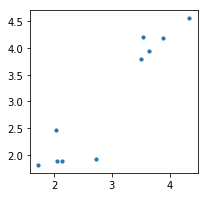

In [4]:
# parameters to generate data
n_features = 2             # number of features (ex; X and Y --- 2)
points_per_feature = 5     # for each category, generate how much data points
centers = [(2, 2), (4, 4)] # specify the centers of each category

# create data
data, labels = make_blobs(
    n_samples = points_per_feature * n_features, # number of total samples
    n_features = n_features,                     # number of features (ex: X and Y --- 2)
    centers = centers,                           # centers --- length of centers matchs the n_features
    cluster_std=0.3,                             # variation
    random_state=5                               # set seed
)

# plot the results
plt.figure(figsize=(3,3))
plt.scatter(data[:, 0], data[:, 1], s=10, alpha=1) # alpha=0.3

In [5]:
print(data.shape) # number of points, number features
data[0:6]         # observe the data

(10, 2)


array([[ 1.72723028,  1.822509  ],
       [ 2.72923136,  1.92437236],
       [ 4.3454173 ,  4.5571993 ],
       [ 3.50056344,  3.78994629],
       [ 2.05628097,  1.90103901],
       [ 3.89235132,  4.18104148]])

### Convert Data to input the model

**Data 1**
- batchsize = 10
- length = 1
- features = 2

In [6]:
# the data need to be in the order:
#   batch size, rows, cols
# So, we first expand to 3-D, then switch the last 2 axes
data_input = data
print(data_input.shape)
data_input = np.expand_dims(data_input, axis=2)
print(data_input.shape)
data_input = np.swapaxes(data_input, 2, 1)
print(data_input.shape)

(10, 2)
(10, 2, 1)
(10, 1, 2)


In [7]:
data_input

array([[[ 1.72723028,  1.822509  ]],

       [[ 2.72923136,  1.92437236]],

       [[ 4.3454173 ,  4.5571993 ]],

       [[ 3.50056344,  3.78994629]],

       [[ 2.05628097,  1.90103901]],

       [[ 3.89235132,  4.18104148]],

       [[ 3.54664613,  4.19345425]],

       [[ 2.03288295,  2.47474434]],

       [[ 3.64217062,  3.93853705]],

       [[ 2.13236825,  1.90073895]]])

**Data 2**
- batchsize = 5
- length = 2
- features = 2

In [8]:
tmp = data
print(tmp.shape)
tmp = np.expand_dims(tmp, axis=2)
print(tmp.shape)
tmp = np.swapaxes(tmp, 2, 1)
tmp = tmp.reshape(5, 2, 2)
print(tmp.shape)
data_input2 = tmp

(10, 2)
(10, 2, 1)
(5, 2, 2)


In [9]:
data_input2

array([[[ 1.72723028,  1.822509  ],
        [ 2.72923136,  1.92437236]],

       [[ 4.3454173 ,  4.5571993 ],
        [ 3.50056344,  3.78994629]],

       [[ 2.05628097,  1.90103901],
        [ 3.89235132,  4.18104148]],

       [[ 3.54664613,  4.19345425],
        [ 2.03288295,  2.47474434]],

       [[ 3.64217062,  3.93853705],
        [ 2.13236825,  1.90073895]]])

### convert labels using the function to_categorical

In [10]:
print(labels.shape)
labels

(10,)


array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0])

In [11]:
binary_labels = to_categorical(labels)
binary_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [12]:
binary_labels = np.int32(binary_labels)

# Construct model

### model 1

In [13]:
model = cnn_1d(
    n_rows=1, 
    n_cols=2,     # number of features
    n_filters=5,  # number of filter
    n_classes=2,  # number of categories / classes
    n_pool=1,     
    learning_rate=0.1)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1, 5)              15        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 5)              0         
_________________________________________________________________
output (Dense)               (None, 1, 2)              12        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


### model 2

In [15]:
model2 = cnn_1d(
    n_rows=2, 
    n_cols=2,     # number of features
    n_filters=5,  # number of filter
    n_classes=2,  # number of categories
    n_pool=1,     
    learning_rate=0.1)

In [16]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2, 2)              0         
_________________________________________________________________
conv1 (Conv1D)               (None, 2, 5)              15        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 5)              0         
_________________________________________________________________
output (Dense)               (None, 2, 2)              12        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


### model 3

In [17]:
model3 = cnn_1d(
    n_rows=1, 
    n_cols=2,     # number of features
    n_filters=1,  # number of filter
    n_classes=2,  # number of categories
    n_pool=1,     
    learning_rate=0.1)

In [18]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1, 1)              3         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 1)              0         
_________________________________________________________________
output (Dense)               (None, 1, 2)              4         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


# Train the Model

### train model 1

In [19]:
label_input = np.expand_dims(binary_labels, axis=1)
label_input2 = np.expand_dims(binary_labels, axis=1).reshape(5, 2, 2)

In [20]:
seed(1)
set_random_seed(2)
model.fit(
    data_input, 
    label_input, 
    batch_size = points_per_feature * n_features,
    epochs=1000,
    validation_split=0.3,
    verbose=0
)

### train model 2

In [21]:
seed(1)
set_random_seed(2)
model2.fit(
    data_input2, 
    label_input2, 
    batch_size = points_per_feature * n_features,
    epochs=1000,
    validation_split=0.3,
    verbose=0
)

### train model 3

In [22]:
seed(1)
set_random_seed(2)
model3.fit(
    data_input, 
    label_input, 
    batch_size = points_per_feature * n_features,
    epochs=1000,
    validation_split=0.3,
    verbose=0
)

# Test data

In [29]:
np.c_[data, labels]

array([[ 1.72723028,  1.822509  ,  0.        ],
       [ 2.72923136,  1.92437236,  0.        ],
       [ 4.3454173 ,  4.5571993 ,  1.        ],
       [ 3.50056344,  3.78994629,  1.        ],
       [ 2.05628097,  1.90103901,  0.        ],
       [ 3.89235132,  4.18104148,  1.        ],
       [ 3.54664613,  4.19345425,  1.        ],
       [ 2.03288295,  2.47474434,  0.        ],
       [ 3.64217062,  3.93853705,  1.        ],
       [ 2.13236825,  1.90073895,  0.        ]])

In [30]:
test_data = np.array(
    [
        [2, 2], [4, 4], [3, 3], [2.0, 4.0], [2.5, 2.5], [0, 0]
    ]
)

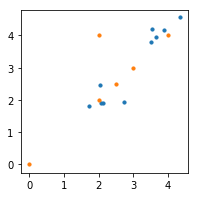

In [31]:
# plot the results
plt.figure(figsize=(3,3))
plt.scatter(data[:, 0], data[:, 1], s=10, alpha=1) # alpha=0.3
plt.scatter(test_data[:, 0], test_data[:, 1], s=10, alpha=1) # alpha=0.3

In [32]:
# test data using model 1
model.predict(np.expand_dims(test_data, 1))

array([[[  9.99428928e-01,   5.71066863e-04]],

       [[  6.89261433e-05,   9.99931097e-01]],

       [[  2.57790238e-01,   7.42209733e-01]],

       [[  3.84193758e-04,   9.99615788e-01]],

       [[  9.61021006e-01,   3.89789902e-02]],

       [[  9.99718130e-01,   2.81820365e-04]]], dtype=float32)

In [33]:
# test data using model 2
tmp = test_data
print(tmp.shape)
tmp = np.expand_dims(tmp, 1)
print(tmp.shape)
tmp = tmp.reshape(3, 2, 2)
print(tmp.shape)
model2.predict(tmp)

(6, 2)
(6, 1, 2)
(3, 2, 2)


array([[[  9.99271214e-01,   7.28804269e-04],
        [  1.05519386e-04,   9.99894500e-01]],

       [[  2.75565296e-01,   7.24434733e-01],
        [  5.67819880e-05,   9.99943256e-01]],

       [[  9.58049297e-01,   4.19506803e-02],
        [  9.99996424e-01,   3.58182115e-06]]], dtype=float32)

In [34]:
# test data using model 3
model3.predict(np.expand_dims(test_data, 1))

array([[[  9.99235868e-01,   7.64162745e-04]],

       [[  9.74980721e-05,   9.99902487e-01]],

       [[  2.63121694e-01,   7.36878335e-01]],

       [[  1.65491743e-04,   9.99834538e-01]],

       [[  9.55768466e-01,   4.42315079e-02]],

       [[  9.99686480e-01,   3.13495373e-04]]], dtype=float32)

# Weights

### weights of Model 1 (#filter = 5)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1, 5)              15        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 5)              0         
_________________________________________________________________
output (Dense)               (None, 1, 2)              12        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [24]:
weights = model.get_weights()
print(len(weights))
for idx in range(len(weights)):
    print("==========================")
    print(weights[idx].shape)
    print(weights[idx])

4
(1, 2, 5)
[[[  1.31177410e-01   8.19572806e-02  -2.68574542e-23  -3.97116019e-05
     2.09502444e-01]
  [  1.31506479e+00   1.21274221e+00   1.18271446e-23  -1.09772314e-04
     1.20702946e+00]]]
(5,)
[-2.76954293 -2.47468877 -0.58827573 -0.51551163 -2.72683764]
(5, 2)
[[ -1.02557528e+00   1.20409024e+00]
 [ -9.84805405e-01   9.98008490e-01]
 [ -3.31991718e-24  -5.23395682e-24]
 [ -4.16079310e-25   4.70978399e-24]
 [ -8.88909638e-01   1.04054546e+00]]
(2,)
[ 4.08697939 -4.08697939]


### weights of Model 2 (#filter = 5)

In [25]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2, 2)              0         
_________________________________________________________________
conv1 (Conv1D)               (None, 2, 5)              15        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 5)              0         
_________________________________________________________________
output (Dense)               (None, 2, 2)              12        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [26]:
weights = model2.get_weights()
print(len(weights))
for idx in range(len(weights)):
    print("==========================")
    print(weights[idx].shape)
    print(weights[idx])

4
(1, 2, 5)
[[[ -1.71352309e-04  -1.13930998e-08  -9.21328663e-15  -3.05128675e-02
     1.38560519e-01]
  [ -7.43678538e-04   3.51667073e-14  -2.73513267e-18   1.67125797e+00
    -1.01126540e+00]]]
(5,)
[-0.51185536 -0.5135926  -0.523211   -2.95543146  3.65756559]
(5, 2)
[[ -2.85871293e-20   6.64408012e-20]
 [ -1.04822464e-23   2.72312733e-23]
 [  1.09487759e-22  -6.31873988e-23]
 [ -1.72609413e+00   2.01739573e+00]
 [  1.29099143e+00  -1.05554116e+00]]
(2,)
[ 1.9785192 -1.9785192]


### weights of Model 3 (#filter = 1)

In [27]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1, 1)              3         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 1)              0         
_________________________________________________________________
output (Dense)               (None, 1, 2)              4         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [28]:
weights = model3.get_weights()
print(len(weights))
for idx in range(len(weights)):
    print("==========================")
    print(weights[idx].shape)
    print(weights[idx])

4
(1, 2, 1)
[[[ 0.06764239]
  [ 2.03026366]]]
(1,)
[-3.9679029]
(1, 2)
[[-1.95099151  1.96041965]]
(2,)
[ 4.03370619 -4.03370619]


# Reconstruct the results from weights

In [35]:
relu = lambda x: np.maximum(x, 0, x)

**Model 3 (# filter = 1, length = 1)**

In [36]:
weights = model3.get_weights()
print(len(weights))
for idx in range(len(weights)):
    print("==========================")
    print(weights[idx].shape)
    print(weights[idx])

4
(1, 2, 1)
[[[ 0.06764239]
  [ 2.03026366]]]
(1,)
[-3.9679029]
(1, 2)
[[-1.95099151  1.96041965]]
(2,)
[ 4.03370619 -4.03370619]


calculate all the test data points

In [37]:
# np.dot(test_data[idx, :], weights[0])

In [38]:
for idx in range(6):
    tmp1 = np.dot(test_data[idx, :], weights[0]) + weights[1]
    tmp1 = relu(tmp1)
    tmp2 = np.dot(tmp1[0], weights[2]) + weights[3]
    tmp3 = np.exp(tmp2)
    tmp4 = [tmp3[0] / np.sum(tmp3), tmp3[1] / np.sum(tmp3)]
    print(tmp4)

[0.9992358375896917, 0.00076416241030841429]
[9.7498060929563079e-05, 0.99990250193907038]
[0.26312144468749088, 0.73687855531250923]
[0.00016549134418983254, 0.99983450865581014]
[0.95576852761203579, 0.044231472387964224]
[0.99968650461564112, 0.00031349538435880044]


In [39]:
model3.predict(np.expand_dims(test_data, 1))

array([[[  9.99235868e-01,   7.64162745e-04]],

       [[  9.74980721e-05,   9.99902487e-01]],

       [[  2.63121694e-01,   7.36878335e-01]],

       [[  1.65491743e-04,   9.99834538e-01]],

       [[  9.55768466e-01,   4.42315079e-02]],

       [[  9.99686480e-01,   3.13495373e-04]]], dtype=float32)

**Model 1 (# filter = 5, length = 1)**

In [40]:
weights = model.get_weights()
print(len(weights))
for idx in range(len(weights)):
    print("==========================")
    print(weights[idx].shape)
    print(weights[idx])

4
(1, 2, 5)
[[[  1.31177410e-01   8.19572806e-02  -2.68574542e-23  -3.97116019e-05
     2.09502444e-01]
  [  1.31506479e+00   1.21274221e+00   1.18271446e-23  -1.09772314e-04
     1.20702946e+00]]]
(5,)
[-2.76954293 -2.47468877 -0.58827573 -0.51551163 -2.72683764]
(5, 2)
[[ -1.02557528e+00   1.20409024e+00]
 [ -9.84805405e-01   9.98008490e-01]
 [ -3.31991718e-24  -5.23395682e-24]
 [ -4.16079310e-25   4.70978399e-24]
 [ -8.88909638e-01   1.04054546e+00]]
(2,)
[ 4.08697939 -4.08697939]


In [41]:
for idx in range(6):
    tmp1 = np.dot(test_data[idx, :], weights[0]) + weights[1]
    tmp1 = relu(tmp1)
    tmp2 = np.dot(tmp1[0], weights[2]) + weights[3]
    tmp3 = np.exp(tmp2)
    tmp4 = [tmp3[0] / np.sum(tmp3), tmp3[1] / np.sum(tmp3)]
    print(tmp4)

[0.9994289330050995, 0.00057106699490047761]
[6.8926175072595754e-05, 0.99993107382492741]
[0.2577900971903308, 0.74220990280966914]
[0.00038419389151814263, 0.99961580610848189]
[0.96102099886053716, 0.038979001139462788]
[0.99971817961948173, 0.00028182038051830568]


In [42]:
model.predict(np.expand_dims(test_data, 1))

array([[[  9.99428928e-01,   5.71066863e-04]],

       [[  6.89261433e-05,   9.99931097e-01]],

       [[  2.57790238e-01,   7.42209733e-01]],

       [[  3.84193758e-04,   9.99615788e-01]],

       [[  9.61021006e-01,   3.89789902e-02]],

       [[  9.99718130e-01,   2.81820365e-04]]], dtype=float32)

# plot the decision boundary

In [43]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [44]:
labels

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0])

In [45]:
data

array([[ 1.72723028,  1.822509  ],
       [ 2.72923136,  1.92437236],
       [ 4.3454173 ,  4.5571993 ],
       [ 3.50056344,  3.78994629],
       [ 2.05628097,  1.90103901],
       [ 3.89235132,  4.18104148],
       [ 3.54664613,  4.19345425],
       [ 2.03288295,  2.47474434],
       [ 3.64217062,  3.93853705],
       [ 2.13236825,  1.90073895]])

In [46]:
res = model.predict(np.expand_dims(test_data, 1))
res = np.squeeze(res, axis=1)
res = np.apply_along_axis(lambda x: 1 if x[0] < x[1] else 0, 1, res)
res

array([0, 1, 1, 1, 0, 0])

In [47]:
plot_decision_boundary(lambda x: model.predict(np.expand_dims(data, 1)), data, labels)

ValueError: cannot reshape array of size 20 into shape (374,362)